# Task2:机器学习用于真实时间序列预测

## 数据导入并绘制序列

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
# 数据导入
X_train = np.load('exp3data/SelfRegulationSCP1/X_train.npy')
y_train = np.load('exp3data/SelfRegulationSCP1/y_train.npy')
X_test = np.load('exp3data/SelfRegulationSCP1/X_test.npy')
y_test = np.load('exp3data/SelfRegulationSCP1/y_test.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((268, 896, 6), (268, 1), (293, 896, 6), (293, 1))

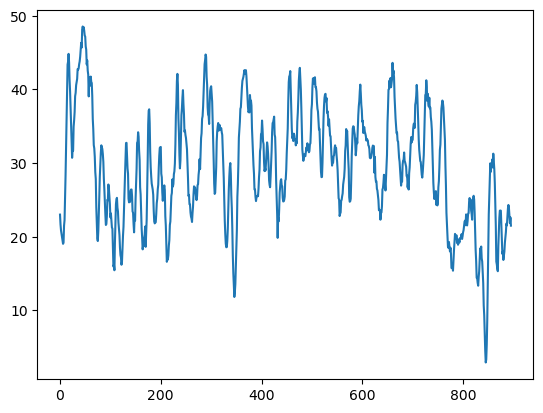

In [4]:
plt.plot(X_train[0,:,0])

## 特征提取

In [238]:
from torch.utils.data import TensorDataset, DataLoader
y_train = torch.tensor(y_train, dtype=torch.double)
y_test = torch.tensor(y_test, dtype=torch.double)
print(y_train.shape, y_test.shape)

torch.Size([268, 1]) torch.Size([293, 1])


### 提取时域特征

#### 均值

In [239]:
# 提取均值——针对每个通道进行提取
X_train_mean = torch.tensor(X_train.mean(axis=2),dtype=torch.double)
X_test_mean = torch.tensor(X_test.mean(axis=2),dtype=torch.double)

train_dataset = TensorDataset(X_train_mean, y_train)

data_loader_mean = DataLoader(train_dataset, batch_size=1, shuffle=False)

X_train_mean.shape, X_test_mean.shape

(torch.Size([268, 896]), torch.Size([293, 896]))

#### 能量

In [6]:
# 提取能量——针对每个通道进行提取
X_train_energy = np.sum(X_train**2, axis=2)
X_test_energy = np.sum(X_test**2, axis=2)
X_train_energy.shape, X_test_energy.shape


((268, 896), (293, 896))

### 提取熵类特征

In [7]:
# 提取近似熵
import antropy

# 对每个样本的每一个通道计算近似熵
X_train_apen, X_test_apen = [], []

for channel in range(X_train.shape[2]):
    for sample in range(X_train.shape[0]):
        X_train_apen.append(antropy.app_entropy(X_train[sample,:,channel], order=2, metric='chebyshev'))

for channel in range(X_test.shape[2]):
    for sample in range(X_test.shape[0]):
        X_test_apen.append(antropy.app_entropy(X_test[sample,:,channel], order=2, metric='chebyshev'))
        
X_train_apen = np.array(X_train_apen).reshape(X_train.shape[0], X_train.shape[2])
X_test_apen = np.array(X_test_apen).reshape(X_test.shape[0], X_test.shape[2])

X_train_apen.shape, X_test_apen.shape

((268, 6), (293, 6))

### 提取频域特征

In [8]:
import yasa
import warnings
warnings.filterwarnings("ignore")

sampling_rate = 256  # 采样率

# 将数据从 (268, 896, 6) 转换为 (268, 6, 896)
# 即将时间点和通道维度进行交换
X_train_trans = np.transpose(X_train, (0, 2, 1))
X_test_trans = np.transpose(X_test, (0, 2, 1))

# 使用 YASA 的 bandpower 函数计算频带能量
# 从前到后分别为 Delta, Theta, Alpha, Beta, Gamma
bands = [(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 13, 'Alpha'), (13, 30, 'Beta'), (30, 100, 'Gamma')]
train_bandpower_features, test_handpower_features = [], []
# 遍历每个样本提取频带能量
for sample in range(X_train_trans.shape[0]):
    single_sample = X_train_trans[sample, :, :]
    sample_bandpower = yasa.bandpower(single_sample, sf=sampling_rate, ch_names=None, bands=bands)
    train_bandpower_features.append(sample_bandpower)
    # print("Bandpower DataFrame columns:", sample_bandpower.columns)
    # print("Single sample bandpower shape:", sample_bandpower.shape)
train_bandpower_features = np.array([df.values for df in train_bandpower_features])
    
for sample in range(X_test_trans.shape[0]):
    single_sample = X_test_trans[sample, :, :]
    sample_bandpower = yasa.bandpower(single_sample, sf=sampling_rate, ch_names=None, bands=bands)
    test_handpower_features.append(sample_bandpower)
test_handpower_features = np.array([df.values for df in test_handpower_features])
    
train_bandpower_features.shape, test_handpower_features.shape


((268, 6, 8), (293, 6, 8))

In [9]:
# 把后两维特征进行融合
X_train_bandpower = train_bandpower_features.reshape(train_bandpower_features.shape[0], -1)
X_test_bandpower = test_handpower_features.reshape(test_handpower_features.shape[0], -1)

X_train_bandpower.shape, X_test_bandpower.shape

((268, 48), (293, 48))

### 提取时频特征

In [10]:
import pywt
from scipy.stats import entropy

def calculate_dwt_features(eeg_data, wavelet='db1', level=3):
    # 计算DWT
    coeffs = pywt.wavedec(eeg_data, wavelet, level=level)
    # 初始化特征字典
    features = []
    # 计算每个小波分量的特征
    for i, coeff in enumerate(coeffs):
        # 计算能量
        energy = np.sum(np.abs(coeff) ** 2)
        features.append(energy)

        # 计算Shannon熵
        prob_dist = np.abs(coeff) / np.sum(np.abs(coeff))
        shannon_entropy = entropy(prob_dist, base=2)
        features.append(shannon_entropy)
    return features

def calculate_variable_TF(sample_data):
    num_channels = sample_data.shape[0]
    TF_values = []

    for i in range(num_channels):
        features=calculate_dwt_features(sample_data[i])
        TF_values+=features

    return TF_values

In [11]:
TF_train = calculate_variable_TF(X_train)
TF_train = np.array(TF_train).reshape(X_train.shape[0], -1)
TF_test = calculate_variable_TF(X_test)
TF_test = np.array(TF_test).reshape(X_test.shape[0], -1)

TF_train.shape, TF_test.shape

((268, 8), (293, 8))

### 神经网络

#### 构建前馈神经网络

In [172]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x): # x shape: (batch, *, *, ...)
        # print('x.view 之前' ,x.shape)
        return x.view(x.shape[0], -1)

#### 定义训练函数

In [173]:
# 参数初始化
def init_net(net):
    for params in net.parameters():
        nn.init.normal_(params, mean=0, std=0.01)

In [244]:
def train(data_loader, X_train, y_train, X_test, y_test, net):
    train_loss = []
    test_loss = []

    loss_fn = nn.BCELoss()
    lr=0.01
    num_epochs=150
    optimizer=torch.optim.Adam(net.parameters(), lr=lr)
    
    # 模型训练
    for epoch in range(num_epochs):  # 外循环训练一轮
        train_l, test_l = 0.0, 0.0
        for X, y in data_loader:
            # print('X shape:', X.shape)
            y_hat = net(X)
            y_hat = y_hat.view(y.shape)
            
            # print('y_hat shape:', y_hat.shape)
            # print('y shape:', y.shape)
            
            l = loss_fn(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 反向传播
            l.backward()
            # 更新参数
            optimizer.step()
            
        # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）      
        train_l = loss_fn(net(X_train), y_train).mean().item()
        test_l = loss_fn(net(X_test), y_test).mean().item()
        
        train_loss.append(train_l)
        test_loss.append(test_l)
        print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))
        
    return train_loss, test_loss

#### 时域特征——均值

In [245]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 896, 1, 128

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
    nn.Sigmoid()
)

训练模型

In [ ]:
train_loss, test_loss = train(data_loader_mean, X_train_mean, y_train, X_test_mean, y_test, net)

绘制损失函数Loss曲线

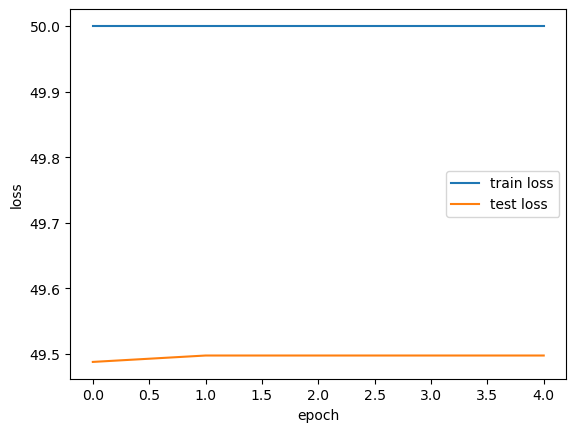

In [202]:
x = np.arange(5)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

#### 时域特征——能量

In [203]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 896, 1, 128

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
    nn.Sigmoid()
)

训练模型

In [204]:
train_loss, test_loss = train(X_train_energy, y_train, X_test_energy, y_test, net)

epoch 0, train loss 49.626866, test loss 49.829352
epoch 1, train loss 49.626866, test loss 49.829352
epoch 2, train loss 49.626866, test loss 49.829352
epoch 3, train loss 49.626866, test loss 49.829352
epoch 4, train loss 49.626866, test loss 49.829352


绘制损失函数Loss曲线

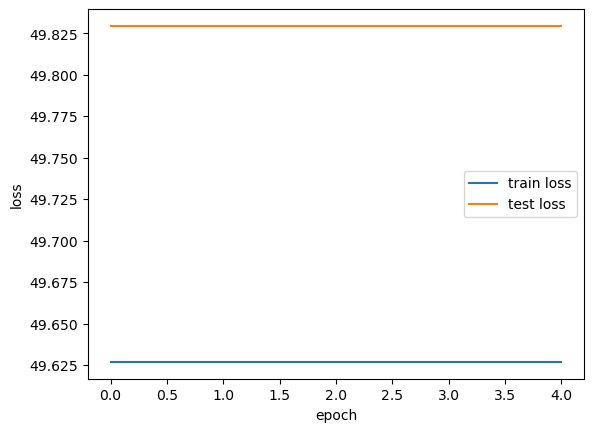

In [205]:
x = np.arange(5)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

#### 熵类特征

In [209]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 6, 1, 3

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
    nn.Sigmoid()
)

训练模型

In [214]:
train_loss, test_loss = train(X_train_mean, y_train, X_test_mean, y_test, net)

ValueError: not enough values to unpack (expected 2, got 1)

绘制损失函数Loss曲线

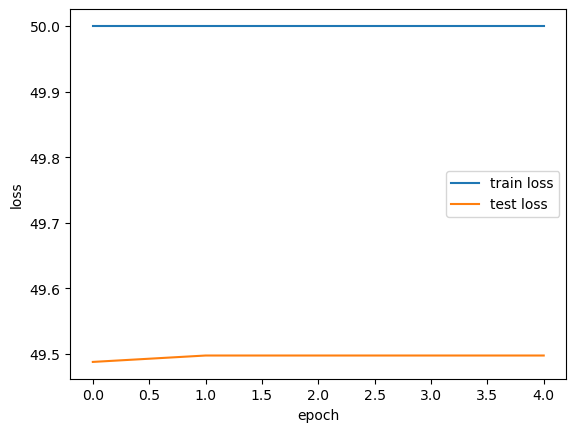

In [ ]:
x = np.arange(5)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

### 使用SVR进行回归预测

In [136]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse

model = SVR(kernel='linear')
# 模型训练
model.fit(train_feature, train_label)
# 测试集预测
test_predict = model.predict(test_feature)
# 计算mse
mse = mse(test_label, test_predict)

print('使用SVR模型的测试集最终MSE:', mse)

使用SVR模型的测试集最终MSE: 309498.71262742573


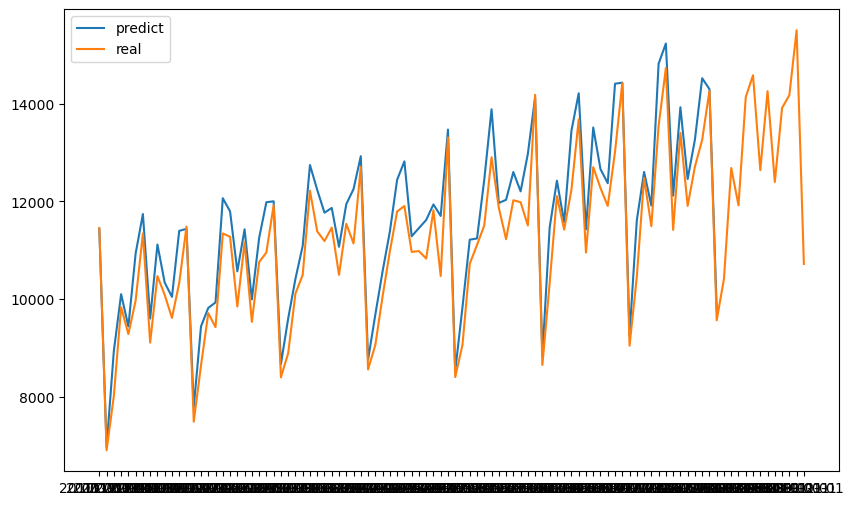

In [137]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='predict')
plt.plot(test, label = 'real')
plt.legend()

### 使用决策树

In [138]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(train_feature, train_label)
# 测试集预测
test_predict = model.predict(test_feature)
# 计算mse
mse = mse(test_label, test_predict)

print('使用决策树模型的测试集最终MSE:', mse)

使用决策树模型的测试集最终MSE: 4804549.337209302


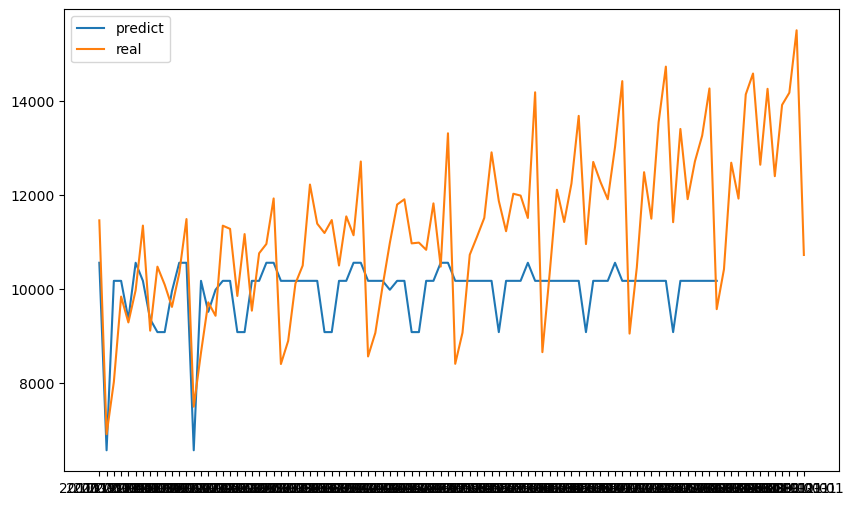

In [139]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='predict')
plt.plot(test, label = 'real')
plt.legend()

### 由此发现，机器学习模型的拟合效果要比神经网络模型拟合效果更好。同时，采用支持向量回归，并且当采用线性核的时候，模型的拟合效果最好。